### Kolmogorov-Arnold Network (KAN) for Gene Expression Prediction: Technical Documentation
This notebook demonstrates the implementation of Kolmogorov-Arnold Networks (KANs) for predicting gene expression patterns. The project uses a KAN to model relationships between genes, specifically predicting the expression of the JUN gene based on related genes' expression levels.
## Overview
The notebook implements a complete workflow for gene expression prediction:

-Data preprocessing of gene expression and network data
-Model creation and training
-Performance evaluation and visualization
-Symbolic formula extraction
-Feature importance analysis

## Key Components
Data Preparation

-Processes gene expression data from H5AD file format
-Uses interaction network data from TSV files to identify related genes
-Splits data into training, validation, and test sets

## Custom Dataset and DataLoader

-KANDataProcessor1 class identifies gene relationships from network files
-KANDataset and associated functions handle batching and data preparation

## Model Architecture

-Uses the KAN (Kolmogorov-Arnold Network) framework
-Configured with specific width, grid, and seed parameters
-Includes symbolic function capabilities for interpretability

## Training Loop

-Implementation with early stopping
-Tracks training, validation, and test loss
-Reports R², RMSE, and MAE metrics
-Uses AdamW optimizer and MSE loss

## Visualization

-Plots training metrics
-Displays model's activation grid
-Visualizes learned feature importance

## Formula Extraction

-Uses auto_symbolic() to convert the neural network into mathematical formulas
-Shows symbolic representation of learned relationships

In [1]:
#!pip install numpy==1.22.4 torch==2.2.2 matplotlib==3.6.2 pandas==2.0.1 scikit_learn==1.1.3 tqdm==4.66.2 setuptools==65.5.0 sympy==1.11.1 seaborn scanpy pykan pyyaml
 










### Data Preprocessing And Model Definition
This class processes gene expression data for KAN (Kolmogorov-Arnold Network) model training. It extracts related genes from interaction network files, prepares input matrices by selecting only relevant gene expression data, and configures model parameters. The prepare_training_data method creates a complete pipeline that takes expression data (h5ad) and network files as input, then returns processed feature matrices, target values, and model configuration needed for training a gene expression prediction model.

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Tuple, List, Dict


class KANDataProcessor1:
    """Processes gene expression data for KAN model training."""

    def __init__(self):
        self.gene_data = {}
        self.sample_names = None
        self.related_genes = {}

    def prepare_training_data(
        self, expression_file: Path, network_file: Path, target_gene: str
    ) -> Tuple[np.ndarray, np.ndarray, Dict]:
        """
        Prepares training data for a target gene.

        Args:
            expression_file: Path to h5ad expression data file
            network_file: Path to network TSV file
            target_gene: Name of target gene

        Returns:
            Tuple of (input matrix, target values, model config)
        """
        # Load and process data
        adata = sc.read_h5ad(expression_file)
        expr_matrix = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
        gene_names = adata.var_names.tolist()
        self.sample_names = adata.obs_names.tolist()

        # Get related genes from network
        network_df = pd.read_csv(network_file, sep="\t")
        related_genes = self._get_related_genes(network_df, target_gene, gene_names)
        self.related_genes[target_gene] = related_genes

        # Prepare input matrix and target vector
        X, y = self._prepare_matrices(
            expr_matrix, gene_names, target_gene, related_genes
        )

        # Create model config
        config = {
            "width": [X.shape[1], 2, 1],
            # "width": X.shape[1],
            "grid": 5,
            "k": 4,
            "seed": 42,
            
            # "feature_names": related_genes,
        }
        # config["feature_names"] = related_genes
        return X.astype(np.float32), y.astype(np.float32), config

    def _get_related_genes(
        self, network_df: pd.DataFrame, target_gene: str, gene_names: List[str]
    ) -> List[str]:
        """Gets list of genes related to target gene from network."""
        source_col, target_col = network_df.columns[:2]
        related = network_df[
            (network_df[source_col] == target_gene)
            | (network_df[target_col] == target_gene)
        ]

        genes = []
        for _, row in related.iterrows():
            gene = (
                row[target_col] if row[source_col] == target_gene else row[source_col]
            )
            if gene in gene_names:
                genes.append(gene)

        return genes

    def _prepare_matrices(
        self,
        expr_matrix: np.ndarray,
        gene_names: List[str],
        target_gene: str,
        related_genes: List[str],
    ) -> Tuple[np.ndarray, np.ndarray]:
        """Prepares input and target matrices."""
        target_idx = gene_names.index(target_gene)
        related_indices = [gene_names.index(gene) for gene in related_genes]

        X = expr_matrix[:, related_indices]
        y = expr_matrix[:, target_idx]

        return X, y

    def get_related_genes(self, target_gene: str) -> List[str]:
        """Returns list of genes related to target gene."""
        return self.related_genes.get(target_gene, [])

KAN Model

In [3]:
a=KANDataProcessor1()
y=a.prepare_training_data(Path("Data/expression_data1.h5ad"), Path("Data/JUN_interactions.tsv"), "JUN")
y

(array([[-0.39712295,  1.0010471 , -0.31169292, ..., -0.3018383 ,
          1.43981   , -0.08644036],
        [-0.39712295,  0.0065413 , -0.31169292, ..., -0.3018383 ,
         -0.32482678, -0.08644036],
        [-0.39712295,  1.1147025 , -0.31169292, ..., -0.3018383 ,
         -0.32482678, -0.08644036],
        ...,
        [-0.39712295, -1.2648143 , -0.31169292, ..., -0.3018383 ,
         -0.32482678, -0.08644036],
        [-0.39712295,  0.89651644, -0.31169292, ..., -0.3018383 ,
         -0.32482678, -0.08644036],
        [-0.39712295,  0.7615987 , -0.31169292, ..., -0.3018383 ,
         -0.32482678, -0.08644036]], dtype=float32),
 array([ 0.9646256 ,  0.7348374 ,  0.8462327 , ..., -1.2689325 ,
         1.258737  , -0.02595734], dtype=float32),
 {'width': [18, 2, 1], 'grid': 5, 'k': 4, 'seed': 42})

The output shows the result of preparing training data for a KAN model designed to predict JUN gene expression. It contains three elements:

1. A feature matrix (X) with dimensions [17041, 18] containing expression values for 18 related genes identified from the JUN interaction network. The data has been transformed to float32 type.

2. A target vector (y) containing the expression values for the JUN gene across all samples.

3. A configuration dictionary for the KAN model with parameters:
   - width: [18, 2, 1] (input dimension, hidden layer, output)
   - grid: 5 (resolution parameter for the KAN)
   - k: 4 (complexity parameter)
   - seed: 42 (for reproducibility)

This prepared dataset will be used to train the KAN model to learn the complex relationships between JUN and its interacting genes.

In [4]:
import kan
from kan import *
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



1. The `KANDataset` class wraps gene expression data in a PyTorch-compatible format, converting NumPy arrays to tensors and providing standard Dataset functionality.

2. The `prepare_data` function splits the data into train (80%), validation (10%), and test (10%) sets using random permutation, then creates DataLoader objects for each set with appropriate batching and shuffling.


In [5]:
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch


class KANDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


def prepare_data(X, y, batch_size=32):
    # Split indices
    indices = np.random.permutation(len(X))
    train_size = int(0.8 * len(X))
    val_size = int(0.1 * len(X))

    train_idx = indices[:train_size]
    val_idx = indices[train_size : train_size + val_size]
    test_idx = indices[train_size + val_size :]

    # Create datasets
    train_loader = DataLoader(
        KANDataset(X[train_idx], y[train_idx]), batch_size=batch_size, shuffle=True
    )
    val_loader = DataLoader(KANDataset(X[val_idx], y[val_idx]), batch_size=batch_size)
    test_loader = DataLoader(
        KANDataset(X[test_idx], y[test_idx]), batch_size=batch_size
    )

    return train_loader, val_loader, test_loader

Sets up and trains a KAN (Kolmogorov-Arnold Network) model to predict JUN gene expression from related genes. It:

1. Initializes the model with the configuration obtained from data preprocessing
2. Creates a training pipeline with early stopping, tracking multiple performance metrics (loss, R², RMSE, MAE)
3. Implements custom training and evaluation functions with proper device handling for GPU acceleration
4. Visualizes training progress with multiple metrics plotted over time

The implementation uses AdamW optimizer with a learning rate of 0.0001 and weight decay of 0.01. Early stopping monitors validation loss with patience=5 to prevent overfitting. The training successfully completes after about 69 epochs when early stopping triggers, saving the best model based on validation performance.

checkpoint directory created: ./model
saving model version 0.0


Training:  66%|▋| 66/100 [31:53<16:25, 28.99s/it, train_loss=0.4343, test_loss=0.4258, val_loss=0.40



Early stopping triggered


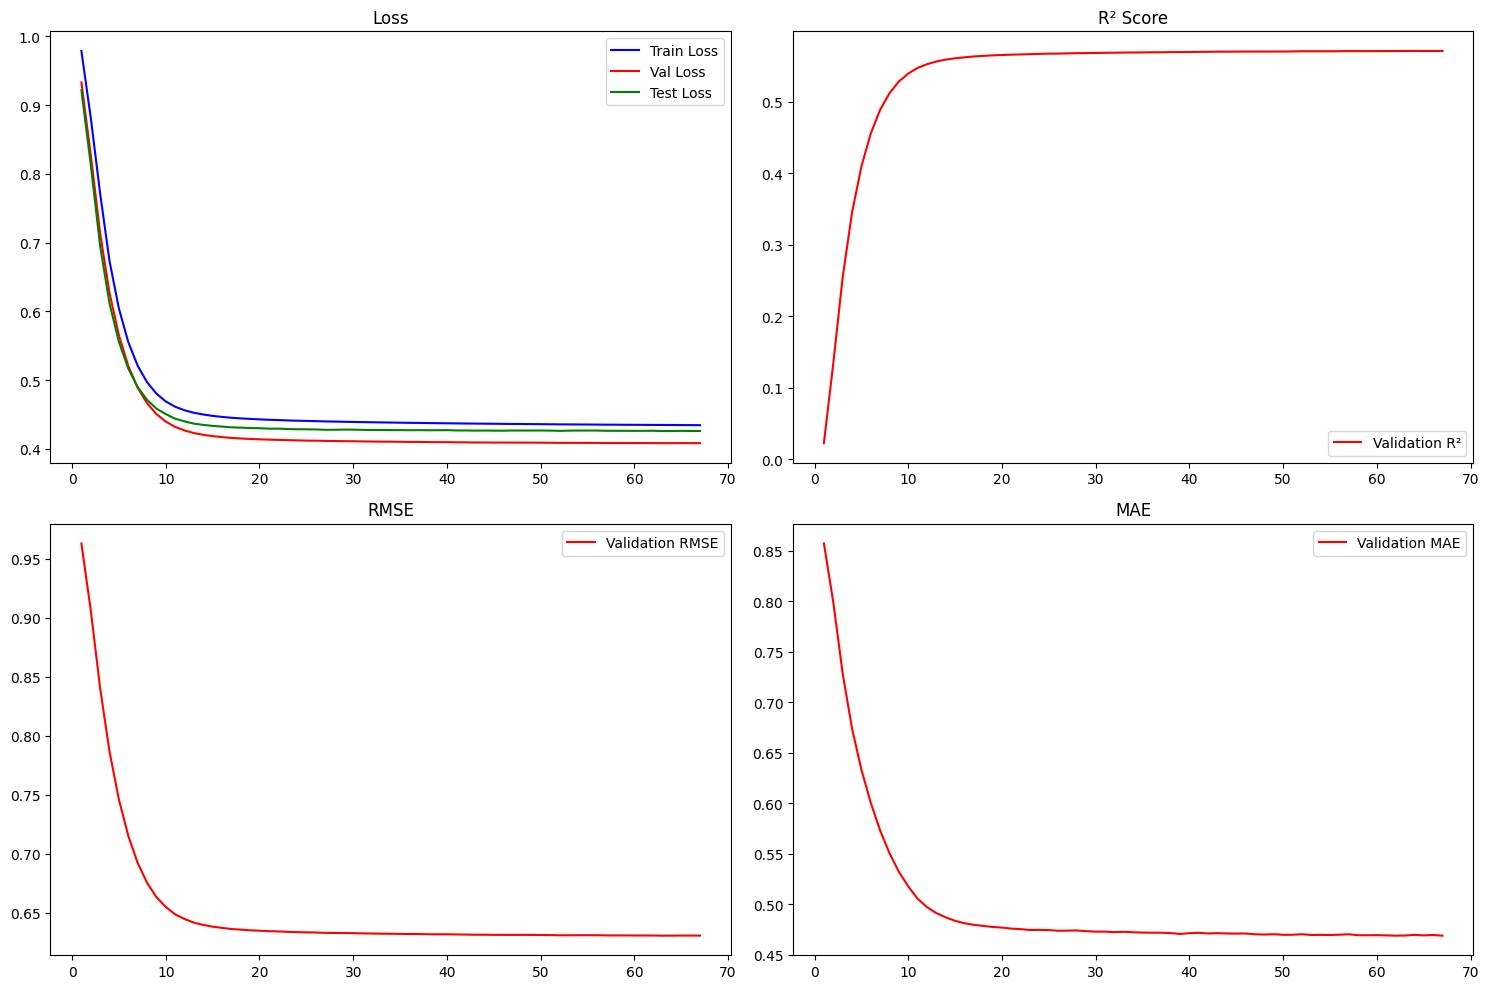

In [6]:
# Unpack the data
X_data, y_target, config = y

# Create KAN model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = KAN(
    width=config["width"],
    grid=config["grid"],
    k=config["k"],
    seed=config["seed"],
    device=device,
).to(device)

# Split and create dataloaders
train_loader, val_loader, test_loader = prepare_data(X_data, y_target)

# Training parameters
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
criterion = torch.nn.MSELoss()
epochs = 100


def r2_score(y_true, y_pred):
    total_sum_squares = torch.sum((y_true - torch.mean(y_true)) ** 2)
    residual_sum_squares = torch.sum((y_true - y_pred) ** 2)
    return 1 - (residual_sum_squares / total_sum_squares)


def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred) ** 2))


def mae(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))


def train_with_early_stopping(
    model,
    train_loader,
    val_loader,
    test_loader,
    optimizer,
    criterion,
    epochs,
    patience=5,
    min_delta=1e-4,
):
    best_val_loss = float("inf")
    patience_counter = 0
    history = []

    pbar = tqdm(range(epochs), desc="Training", ncols=100, position=0, leave=True)
    for epochs in pbar:
        # Training phase
        model.train()
        train_loss, train_r2, train_rmse, train_mae = 0, 0, 0, 0
        for X_batch, y_batch in train_loader:
            loss = train_batch(model, X_batch, y_batch, optimizer, criterion)
            train_loss += loss

        # Validation phase
        model.eval()
        val_loss, val_r2, val_rmse, val_mae = 0, 0, 0, 0
        test_loss, test_r2, test_rmse, test_mae = 0, 0, 0, 0

        with torch.no_grad():
            for X, y in val_loader:
                predictions = model(X.to(device)).squeeze()
                y = y.to(device)
                val_loss += criterion(predictions, y).item()
                val_r2 += r2_score(y, predictions)
                val_rmse += rmse(y, predictions)
                val_mae += mae(y, predictions)

            for X, y in test_loader:
                predictions = model(X.to(device)).squeeze()
                y = y.to(device)
                test_loss += criterion(predictions, y).item()
                test_r2 += r2_score(y, predictions)
                test_rmse += rmse(y, predictions)
                test_mae += mae(y, predictions)

        # Normalize metrics
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        test_loss /= len(test_loader)
        val_r2 /= len(val_loader)
        val_rmse /= len(val_loader)
        val_mae /= len(val_loader)
        test_r2 /= len(test_loader)
        test_rmse /= len(test_loader)
        test_mae /= len(test_loader)

        # Store metrics
        history.append((train_loss, val_loss, test_loss, val_r2,val_rmse, val_mae))

        # Update progress bar
        pbar.set_postfix(
            {
                "train_loss": f"{train_loss:.4f}",
                "test_loss": f"{test_loss:.4f}",
                "val_loss": f"{val_loss:.4f}",
                "val_r2": f"{val_r2:.4f}",
                "val_rmse": f"{val_rmse:.4f}",
            }
        )

        # Early stopping check
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("\nEarly stopping triggered")
            model.load_state_dict(torch.load("best_model.pt"))
            break

    return history


def train_batch(model, X, y, optimizer, criterion):
    X, y = X.to(device), y.to(device)
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output.squeeze(), y)
    loss.backward()
    optimizer.step()
    return loss.item()


def plot_training_metrics(history):
    epochs = np.array(range(1, len(history) + 1))
    metrics = [
        np.array([x.cpu().numpy() if torch.is_tensor(x) else x for x in m])
        for m in zip(*history)
    ]

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Loss Plot
    ax1.plot(epochs, metrics[0], "b-", label="Train Loss")
    ax1.plot(epochs, metrics[1], "r-", label="Val Loss")
    ax1.plot(epochs, metrics[2], "g-", label="Test Loss")
    ax1.set_title("Loss")
    ax1.legend()

    # R² Plot
    ax2.plot(epochs, metrics[3], "r-", label="Validation R²")
    ax2.set_title("R² Score")
    ax2.legend()

    # RMSE Plot
    ax3.plot(epochs, metrics[4], "r-", label="Validation RMSE")
    ax3.set_title("RMSE")
    ax3.legend()

    # MAE Plot
    ax4.plot(epochs, metrics[5], "r-", label="Validation MAE")
    ax4.set_title("MAE")
    ax4.legend()

    plt.tight_layout()
    plt.savefig("training_metrics.png")
    plt.show()


# Usage
history = train_with_early_stopping(
    model, train_loader, val_loader, test_loader,optimizer, criterion, epochs
)
plot_training_metrics(history)

## Symbolic Formula Generation

In [7]:
model.auto_symbolic()

fixing (0,0,0) with 0, r2=0.0, c=0
fixing (0,0,1) with 1/x^3, r2=1.0, c=3
fixing (0,1,0) with sin, r2=0.9996917843818665, c=2
fixing (0,1,1) with x, r2=0.9866153597831726, c=1
fixing (0,2,0) with exp, r2=1.0000007152557373, c=2
fixing (0,2,1) with exp, r2=1.0000005960464478, c=2
fixing (0,3,0) with x^2, r2=0.9998230338096619, c=2
fixing (0,3,1) with x^2, r2=0.9995185136795044, c=2
fixing (0,4,0) with log, r2=0.999010443687439, c=2
fixing (0,4,1) with x^2, r2=0.9999939799308777, c=2
fixing (0,5,0) with 1/x^2, r2=1.0000005960464478, c=2
fixing (0,5,1) with exp, r2=1.0000008344650269, c=2
fixing (0,6,0) with exp, r2=1.0000007152557373, c=2
fixing (0,6,1) with 1/x^2, r2=1.0000007152557373, c=2
fixing (0,7,0) with 0, r2=0.0, c=0
fixing (0,7,1) with 0, r2=0.0, c=0
fixing (0,8,0) with sin, r2=0.9998640418052673, c=2
fixing (0,8,1) with cos, r2=0.9983952045440674, c=2
fixing (0,9,0) with exp, r2=1.0000007152557373, c=2
fixing (0,9,1) with 1/x^2, r2=1.0000007152557373, c=2
fixing (0,10,0) with 

In [8]:
from kan.utils import ex_round
ex_round(model.symbolic_formula()[0][0], 4)

0.0196*x_14 + 0.0314*x_2 + 0.0344*(0.4436 - x_11)**2 + 0.0975*(-0.765*x_4 - 1)**2 + 0.1941*(-0.6465*x_5 - 1)**2 - 0.141*cos(1.1523*x_9 + 7.5695) + 0.507*cos(-0.0483*x_14 + 0.1831*(-x_11 - 0.1396)**4 + 0.3094*(-0.6484*x_4 - 1)**2 + 0.008*exp(2.0246*x_7) + 0.1008*log(3.532*x_5 + 4.9036) + 0.9226*sin(0.6228*x_2 - 6.9692) - 0.3862*sin(1.2037*x_9 + 9.2119) - 0.001*tan(3.016*x_13 - 8.6054) - 7.408 + 0.0007*exp(-10.0*x_3) - 0.0001*exp(-8.5366*x_10)) - 0.0004*tan(8.3959*x_13 - 3.6202) - 0.6419 + 0.0018*exp(-6.1519*x_3)

## Plotting the model architecture

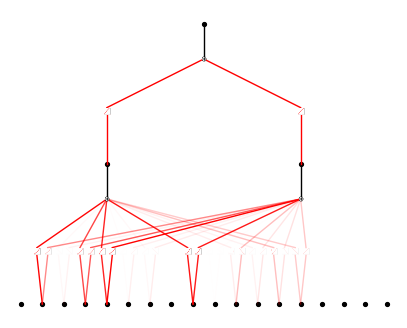

In [9]:
model.plot(beta=10)

## Analyzing the input feature contributions to the network

In [10]:
def visualize_kan_node_importance(model, gene_names):
    """
    Visualize KAN's feature importance scores with gene names in their original node order.

    Args:
        model: A trained KAN model
        gene_names: List of gene names corresponding to input features

    Returns:
        Dictionary of gene importance scores in original order
    """
    # Set model to evaluation mode
    model.eval()

    # Get feature importance scores directly from the model
    feature_scores = model.feature_score.cpu().detach().numpy()

    # Map scores to gene names (maintaining original order)
    gene_importance = {}
    for i, gene in enumerate(gene_names):
        if i < len(feature_scores):
            gene_importance[gene] = float(feature_scores[i])

    # Normalize scores for better interpretability (optional)
    total = sum(abs(v) for v in gene_importance.values())
    if total > 0:
        gene_importance = {k: abs(v) / total for k, v in gene_importance.items()}

    # Create visualization (maintaining original order)
    plt.figure(figsize=(8, 6))
    genes = list(gene_importance.keys())  # Keep original order
    scores = list(gene_importance.values())  # Keep original order

    plt.bar(genes, scores)
    plt.xticks(rotation=90, ha="right")
    plt.title("Gene Importance Scores from KAN (Original Node Order)")
    plt.ylabel("Normalized Importance")
    plt.xlabel("Genes")
    plt.tight_layout()
    plt.show()

    return gene_importance

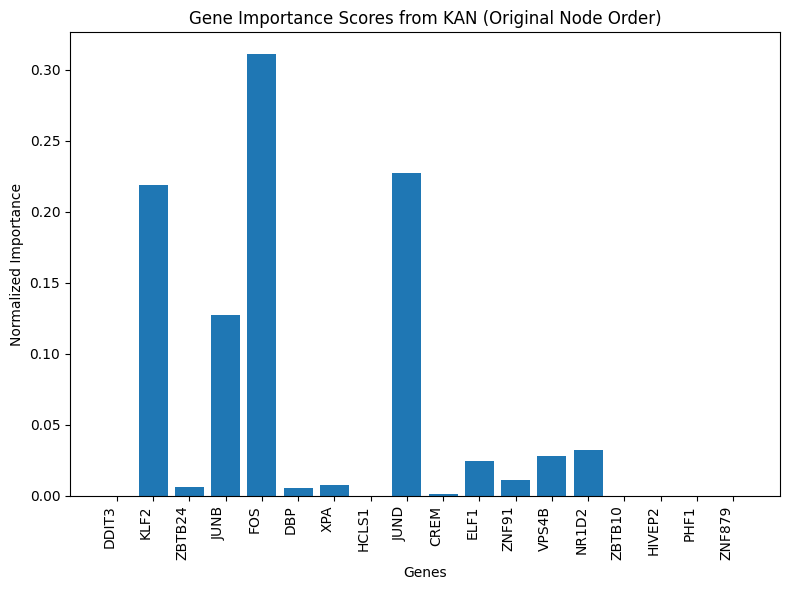

In [11]:
# Load data
network_df = pd.read_csv("Data/JUN_interactions.tsv", sep="\t")
adata = sc.read_h5ad("Data/expression_data1.h5ad")
gene_names = adata.var_names.tolist()

# Get related genes
a = KANDataProcessor1()
X_data, y_target, config = a.prepare_training_data(
    Path("Data/expression_data1.h5ad"), Path("Data/JUN_interactions.tsv"), "JUN"
)
related_genes = a.get_related_genes("JUN")

# Then move model to device
model = model.to(device)

gene_importance = visualize_kan_node_importance(model, related_genes)

In [12]:
feature_scores = model.feature_score.cpu().detach().numpy()
feature_scores

array([0.        , 0.29266697, 0.00787871, 0.1709128 , 0.4161768 ,
       0.00764698, 0.01009998, 0.        , 0.30418217, 0.00129446,
       0.03299863, 0.01532735, 0.03735226, 0.04303043, 0.        ,
       0.        , 0.        , 0.        ], dtype=float32)


First 20 sample results:
    Sample    Actual  Predicted     Error  Squared_Error
0        0  0.964626   0.333049  0.631577       0.398889
1        1  0.734837   0.034037  0.700800       0.491121
2        2  0.846233   0.723260  0.122972       0.015122
3        3  0.126544  -0.001248  0.127792       0.016331
4        4  1.129296  -0.108420  1.237716       1.531942
5        5 -0.025733  -0.018433 -0.007300       0.000053
6        6 -1.268932  -1.239632 -0.029300       0.000859
7        7 -1.268932  -0.673849 -0.595084       0.354125
8        8 -1.268932  -0.620335 -0.648598       0.420679
9        9 -1.268932   0.476727 -1.745659       3.047326
10      10  0.925255   0.907231  0.018024       0.000325
11      11  0.978879   0.835488  0.143391       0.020561
12      12  0.777493   0.145327  0.632166       0.399634
13      13  0.862433   0.848706  0.013727       0.000188
14      14  0.791116   0.588221  0.202895       0.041166
15      15  1.005335   0.622900  0.382434       0.146256
16   

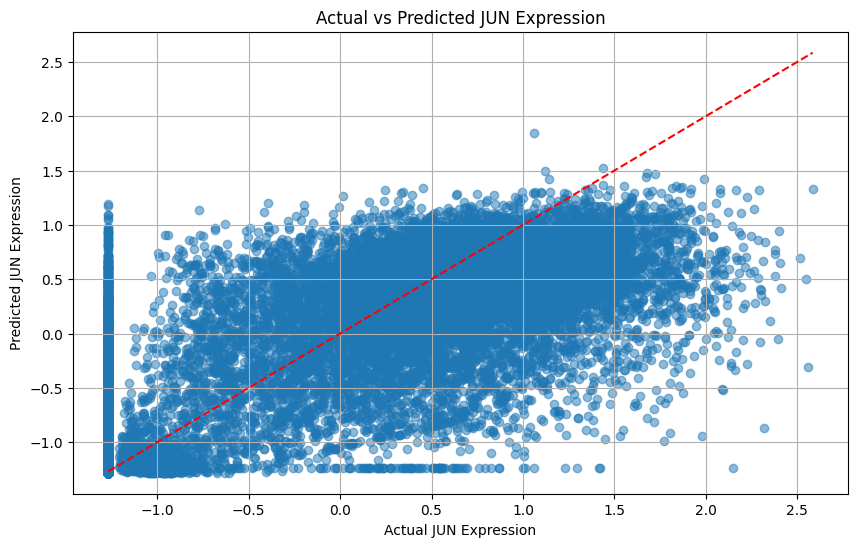

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def evaluate_formula(X_data, gene_names):
    # Create mapping between gene names and column indices
    gene_indices = {gene: idx for idx, gene in enumerate(gene_names)}

    # Initialize predictions array
    n_samples = X_data.shape[0]
    y_pred = np.zeros(n_samples)

    for i in range(n_samples):
        # Extract values for the key genes
        FOS = X_data[i, gene_indices["FOS"]]
        JUND = X_data[i, gene_indices["JUND"]]
        KLF2 = X_data[i, gene_indices["KLF2"]]
        JUNB = X_data[i, gene_indices["JUNB"]]

        # Apply reduced formula (preserving original coefficients)
        y_pred[i] = (
            0.0314 * KLF2
            + 0.0975*(-0.765 * JUNB - 1) ** 2
            + 0.1941*(-0.6465 * FOS - 1) ** 2
            - 0.141 * np.cos(1.1523 * JUND + 7.5695)
            + 0.507
            * np.cos(
                0.3094*(-0.6484 * JUNB - 1) ** 2
                + 0.1008 * np.log(3.532 * FOS + 4.9036)
                + 0.9226 * np.sin(0.6228 * KLF2 - 6.9692)
                - 0.3862 * np.sin(1.2037 * JUND + 9.2119)
                - 7.408
            )-0.6419
        )

    return y_pred


# Usage example:
processor = KANDataProcessor1()
X, y, config = processor.prepare_training_data(
    Path("Data/expression_data1.h5ad"), Path("Data/JUN_interactions.tsv"), "JUN"
)


# Get the related genes in order
related_genes = processor.get_related_genes("JUN")

# Evaluate the formula
y_pred = evaluate_formula(X, related_genes)
# Store results for individual sample inspection
results = []
for i in range(len(y)):
    results.append(
        {
            "Sample": i,
            "Actual": float(y[i]),  # Convert to native Python float for better display
            "Predicted": float(y_pred[i]),
            "Error": float(y[i] - y_pred[i]),
            "Squared_Error": float((y[i] - y_pred[i]) ** 2),
        }
    )

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Display first 20 samples
print("\nFirst 20 sample results:")
print(results_df.head(20))

# Calculate and display overall metrics
mse = np.mean((y_pred - y) ** 2)
corr = np.corrcoef(y_pred, y)[0, 1]
print(f"\nOverall metrics:")
print(f"Mean Squared Error: {mse}")
print(f"Correlation: {corr}")

# Save detailed results to CSV
target_gene = "JUN"
csv_path = f"{target_gene}_predictions.csv"
results_df.to_csv(csv_path, index=False)
print(f"\nDetailed predictions saved to {csv_path}")

# Create visualization
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, alpha=0.5)
plt.plot([min(y), max(y)], [min(y), max(y)], "r--")  # Diagonal line
plt.xlabel("Actual JUN Expression")
plt.ylabel("Predicted JUN Expression")
plt.title("Actual vs Predicted JUN Expression")
plt.grid(True)